In [1]:
import os
import numpy as np
import pandas as pd
#from sklearn.linear_model import Lasso, LassoCV, LinearRegression
#from sklearn.model_selection import KFold
from utilities import cal_score

In [2]:
stack_idx = '12'
models = '1-18,20'
use_test_kfold = set([2, 7, 8, 12, 13])

#is_per_area = False
#is_log = False

### Read CV predictions and test

In [3]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [4]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]


In [5]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [6]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [7]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [8]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

print('CV predictions:')
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

CV predictions:
No. 0 file: model-01-lgb-cv.csv
No. 1 file: model-02-keras-search-cv.csv
No. 2 file: model-03-lgb-feats-selection-cv.csv
No. 3 file: model-04-lgb-PCA-cv.csv
No. 4 file: model-05-lgb-wo-per-area-cv.csv
No. 5 file: model-06-lgb-lr0.001-cv.csv
No. 6 file: model-07-keras-embedding-cv.csv
No. 7 file: model-08-keras-search-long-cv.csv
No. 8 file: model-09-lgb-feats-selection-75-cv.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-cv.csv
No. 10 file: model-11-rf-cv.csv
No. 11 file: model-12-predict-keras-search-prelu-cv.csv
No. 12 file: model-13-predict-keras-he_uni-cv.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
No. 17 file: model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
No. 18 file: model-20-lgb-lr-0.0008-mix5-cv.csv
Test predictions:
No. 0 f

In [9]:
cv.head()

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_17,log_parea_pred_17,pred_18,log_pred_18,log_parea_pred_18,pred_20,log_pred_20,log_parea_pred_20,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.392766,12.163663,6.631879e+05,13.404815,12.175712,6.385893e+05,13.367018,12.137915,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.956603,13.560036,3.092403e+06,14.944459,13.547892,3.171011e+06,14.969561,13.572994,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.096597,14.376642,9.773138e+06,16.095148,14.375193,9.802951e+06,16.098194,14.378239,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.357815,13.750469,1.266263e+07,16.354166,13.746819,1.266383e+07,16.354260,13.746914,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.919882,12.374856,1.128016e+06,13.935971,12.390946,1.124958e+06,13.933257,12.388231,13.544637,11.999613


In [10]:
test.head()

,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_16,pred_17,log_pred_17,log_parea_pred_17,pred_18,log_pred_18,log_parea_pred_18,pred_20,log_pred_20,log_parea_pred_20
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.217310,1.449905e+07,16.489594,15.260487,1.396801e+07,16.452280,15.223173,1.478805e+07,16.509330,15.280223
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.136639,3.917960e+06,15.181082,13.136463,3.908782e+06,15.178737,13.134118,3.918591e+06,15.181243,13.136624
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.690042,1.063343e+07,16.179513,13.680493,1.073427e+07,16.188952,13.689931,1.069408e+07,16.185201,13.686181
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.808737,6.119193e+06,15.626941,14.815009,6.084894e+06,15.621320,14.809388,6.033528e+06,15.612843,14.800910
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.125206,1.084776e+06,13.896885,12.136623,1.087941e+06,13.899798,12.139536,1.089268e+06,13.901017,12.140755


### Check models scores

In [11]:
scores_models = {idx_model: cal_score(cv['total_price'], cv[f'pred_{idx_model}'])
                 for idx_model in idx_models}

In [12]:
for i, (idx_model, s) in enumerate(scores_models.items()):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%s)

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-20 5908.874040


### Search subset model mean 

In [13]:
def get_prefix(is_per_area, is_log):
    if is_log:
        if is_per_area:
            col_prefix = 'log_parea_pred'
        else:
            col_prefix = 'log_pred'
    else:
        if is_per_area:
            raise 'Not support'
        else:
            col_prefix = 'pred'
    return col_prefix

In [14]:
def mean_subset(df, idx_models, is_per_area, is_log):
    col_prefix = get_prefix(is_per_area, is_log)
    cols_models = [col_prefix+'_'+str(i) for i in idx_models]
    return df[cols_models].mean(axis=1)

In [15]:
def predict_mean_subset(df, idx_models, is_per_area, is_log):
    y_pred = mean_subset(df, idx_models, is_per_area, is_log)
    y_pred_final = y_pred
    if is_log:
        y_pred_final = np.expm1(y_pred_final)
    if is_per_area:
        y_pred_final = y_pred_final * df['building_area']
    return y_pred_final

In [16]:
def search_mean_subset(cv, idx_models, is_per_area, is_log):
    idx_models_subset = idx_models.copy()
    result_list = []
    y_pred_cv = predict_mean_subset(cv, idx_models_subset, is_per_area=is_per_area, is_log=is_log)
    score = cal_score(cv['total_price'], y_pred_cv)
    print('%.6f'%score, idx_models_subset)
    result_list.append([score, idx_models_subset])
    while len(idx_models_subset) > 1:
        print('N models remained:', len(idx_models_subset))
        result_list_subset = []
        for i_rm in range(len(idx_models_subset)):
            idx_models_subset_next = idx_models_subset[:i_rm]+idx_models_subset[i_rm+1:]
            y_pred_cv = predict_mean_subset(cv, idx_models_subset_next, is_per_area=is_per_area, is_log=is_log)
            score = cal_score(cv['total_price'], y_pred_cv)
            print('%.6f'%score, idx_models_subset_next)
            result_list_subset.append([score, idx_models_subset_next])
        result_list.extend(result_list_subset)
        result_list_subset.sort(key=lambda x: x[0], reverse=True)
        print('Best of the round:', result_list_subset[0][0], result_list_subset[0][1])
        idx_models_subset = result_list_subset[0][1]
        print()
    result_list.sort(key=lambda x: x[0], reverse=True)
    return result_list

#### Log mean

In [17]:
result_list_log = search_mean_subset(cv, idx_models, is_per_area=False, is_log=True)

5925.874567 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
N models remained: 19
5926.874494 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5929.874620 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5925.874472 [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5922.874517 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5924.874371 [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5926.874485 [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5921.874593 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5925.874584 [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5928.874493 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5926.874474 [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5935.875089 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20]
5926.874631 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 1

5932.874788 [1, 4, 7, 8, 10, 13, 14, 17, 18, 20]
5945.875242 [1, 4, 5, 8, 10, 13, 14, 17, 18, 20]
5941.875095 [1, 4, 5, 7, 10, 13, 14, 17, 18, 20]
5941.874923 [1, 4, 5, 7, 8, 13, 14, 17, 18, 20]
5938.875189 [1, 4, 5, 7, 8, 10, 14, 17, 18, 20]
5939.874916 [1, 4, 5, 7, 8, 10, 13, 17, 18, 20]
5940.874907 [1, 4, 5, 7, 8, 10, 13, 14, 18, 20]
5940.874892 [1, 4, 5, 7, 8, 10, 13, 14, 17, 20]
5939.874894 [1, 4, 5, 7, 8, 10, 13, 14, 17, 18]
Best of the round: 5945.875242201832 [1, 4, 5, 8, 10, 13, 14, 17, 18, 20]

N models remained: 10
5936.875230 [4, 5, 8, 10, 13, 14, 17, 18, 20]
5939.875262 [1, 5, 8, 10, 13, 14, 17, 18, 20]
5931.875021 [1, 4, 8, 10, 13, 14, 17, 18, 20]
5939.875107 [1, 4, 5, 10, 13, 14, 17, 18, 20]
5937.875204 [1, 4, 5, 8, 13, 14, 17, 18, 20]
5935.875190 [1, 4, 5, 8, 10, 14, 17, 18, 20]
5938.875197 [1, 4, 5, 8, 10, 13, 17, 18, 20]
5939.875182 [1, 4, 5, 8, 10, 13, 14, 18, 20]
5937.875165 [1, 4, 5, 8, 10, 13, 14, 17, 20]
5938.875169 [1, 4, 5, 8, 10, 13, 14, 17, 18]
Best of the ro

In [18]:
display(result_list_log[:10])

[[5948.87516134944, [1, 4, 5, 7, 8, 10, 13, 14, 16, 17, 18, 20]],
 [5947.875198566793, [3, 4, 5, 7, 8, 10, 13, 14, 16, 17, 18, 20]],
 [5947.875167777145, [1, 3, 4, 5, 7, 8, 10, 13, 16, 17, 18, 20]],
 [5946.875077305592, [1, 2, 3, 4, 5, 7, 8, 10, 13, 14, 16, 17, 18, 20]],
 [5945.875242201832, [1, 4, 5, 8, 10, 13, 14, 17, 18, 20]],
 [5945.875157151499, [1, 3, 4, 5, 7, 8, 10, 13, 14, 16, 18, 20]],
 [5945.875077231472, [1, 2, 3, 4, 5, 7, 8, 13, 14, 15, 16, 17, 18, 20]],
 [5945.875066649048, [1, 2, 4, 5, 7, 8, 10, 13, 14, 15, 16, 17, 18, 20]],
 [5944.875302801468, [5, 8, 10, 14, 17, 18, 20]],
 [5944.875173822172, [1, 3, 4, 5, 7, 8, 13, 14, 16, 17, 18, 20]]]

In [19]:
best_models_subset_log = result_list_log[0][1]
print('Best score and subset:', '%.6f'%result_list_log[0][0], best_models_subset_log)
for idx_model in best_models_subset_log:
    print('model-%02d'%idx_model, '%.6f'%scores_models[idx_model])

Best score and subset: 5948.875161 [1, 4, 5, 7, 8, 10, 13, 14, 16, 17, 18, 20]
model-01 5870.873059
model-04 5713.867808
model-05 5724.869598
model-07 5171.836449
model-08 5514.858826
model-10 5897.873845
model-13 5506.858055
model-14 5908.873901
model-16 5907.874126
model-17 5905.874165
model-18 5908.874297
model-20 5908.874040


In [20]:
# per area or not for the mean ensemble model are the same
#result_list_per_area_log = search_mean_subset(cv, idx_models, is_per_area=True, is_log=True)
#result_list_per_area_log

#### Linear mean

In [21]:
result_list_none = search_mean_subset(cv, idx_models, is_per_area=False, is_log=False)

5921.873281 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
N models remained: 19
5920.873146 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5926.873409 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5922.873124 [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5919.873193 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5916.873041 [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5920.873134 [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5918.873858 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5923.873305 [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5917.873144 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5918.873123 [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20]
5929.873915 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20]
5927.873364 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 1

5933.873470 [3, 4, 6, 7, 8, 10, 13, 14, 15, 17, 20]
5941.873601 [3, 4, 5, 7, 8, 10, 13, 14, 15, 17, 20]
5940.874782 [3, 4, 5, 6, 8, 10, 13, 14, 15, 17, 20]
5932.873772 [3, 4, 5, 6, 7, 10, 13, 14, 15, 17, 20]
5940.873593 [3, 4, 5, 6, 7, 8, 13, 14, 15, 17, 20]
5936.873894 [3, 4, 5, 6, 7, 8, 10, 14, 15, 17, 20]
5943.873586 [3, 4, 5, 6, 7, 8, 10, 13, 15, 17, 20]
5940.873594 [3, 4, 5, 6, 7, 8, 10, 13, 14, 17, 20]
5940.873570 [3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 20]
5934.873562 [3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17]
Best of the round: 5943.873586327043 [3, 4, 5, 6, 7, 8, 10, 13, 15, 17, 20]

N models remained: 11
5942.873320 [4, 5, 6, 7, 8, 10, 13, 15, 17, 20]
5930.873443 [3, 5, 6, 7, 8, 10, 13, 15, 17, 20]
5931.873210 [3, 4, 6, 7, 8, 10, 13, 15, 17, 20]
5937.873334 [3, 4, 5, 7, 8, 10, 13, 15, 17, 20]
5939.874730 [3, 4, 5, 6, 8, 10, 13, 15, 17, 20]
5933.873611 [3, 4, 5, 6, 7, 10, 13, 15, 17, 20]
5935.873314 [3, 4, 5, 6, 7, 8, 13, 15, 17, 20]
5941.873745 [3, 4, 5, 6, 7, 8, 10, 15, 17, 20]
5931.

In [22]:
display(result_list_none[:10])

[[5944.873955044229, [3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17, 18, 20]],
 [5944.873920787138, [1, 3, 4, 5, 6, 7, 8, 10, 13, 15, 17, 18, 20]],
 [5944.873784689776, [3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17, 20]],
 [5944.873205958315, [4, 5, 6, 7, 8, 10, 15, 20]],
 [5943.873811670045, [3, 4, 5, 6, 7, 8, 10, 13, 15, 17, 18, 20]],
 [5943.873797861853, [3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 18, 20]],
 [5943.873586327043, [3, 4, 5, 6, 7, 8, 10, 13, 15, 17, 20]],
 [5943.873231032607, [4, 5, 6, 7, 8, 15, 17, 20]],
 [5942.874838421114, [3, 4, 5, 6, 8, 10, 13, 14, 15, 17, 18, 20]],
 [5942.874128054333, [1, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16, 17, 18, 20]]]

In [23]:
best_models_subset_none = result_list_none[0][1]
print('Best score and subset:', '%.6f'%result_list_none[0][0], best_models_subset_none)
for idx_model in best_models_subset_none:
    print('model-%02d'%idx_model, '%.6f'%scores_models[idx_model])

Best score and subset: 5944.873955 [3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17, 18, 20]
model-03 5877.873452
model-04 5713.867808
model-05 5724.869598
model-06 5886.873769
model-07 5171.836449
model-08 5514.858826
model-10 5897.873845
model-13 5506.858055
model-14 5908.873901
model-15 5900.873836
model-17 5905.874165
model-18 5908.874297
model-20 5908.874040


### Compute submission for mean log

In [24]:
import matplotlib.pyplot as plt

In [25]:
print('Predict for mean log with', best_models_subset_log)
test['total_price'] = predict_mean_subset(test, best_models_subset_log, is_per_area=False, is_log=True)

Predict for mean log with [1, 4, 5, 7, 8, 10, 13, 14, 16, 17, 18, 20]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


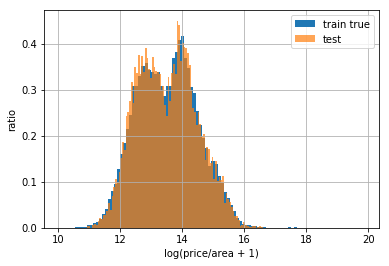

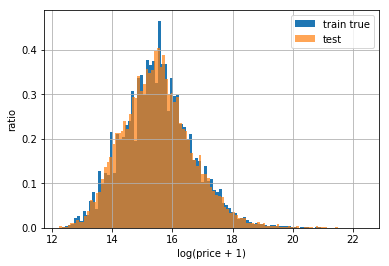

In [26]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [27]:
test[['building_id', 'total_price']].check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.379369e+07
1,BTshNOJyKHnT2YIT,3.922201e+06
2,dhdymr0lV8N5kZOT,1.113316e+07
3,VEwyGGMcD56w5BOc,6.040533e+06
4,wmUeMoJZfsqaSX9b,1.073026e+06
9995,UEeCDaAJzPwdKKKA,1.232692e+06
9996,i0fgbPaQsDWs7Q87,4.724260e+07
9997,YunNwAhcqkf6YclI,1.097615e+06
9998,A2NotxtRY9MYoWMl,2.982505e+06
9999,kKvgBXiA50gRmQhP,3.130035e+06


shape = (10000, 2)


In [28]:
output_filename = 'output/stack_meanlog_{}_{}.csv'.format(stack_idx, models)
print('Output file to:', output_filename)

Output file to: output/stack_meanlog_12_1-18,20.csv


In [29]:
test[['building_id', 'total_price']].to_csv(output_filename, index=False)

In [30]:
pd.read_csv(output_filename).check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.379369e+07
1,BTshNOJyKHnT2YIT,3.922201e+06
2,dhdymr0lV8N5kZOT,1.113316e+07
3,VEwyGGMcD56w5BOc,6.040533e+06
4,wmUeMoJZfsqaSX9b,1.073026e+06
9995,UEeCDaAJzPwdKKKA,1.232692e+06
9996,i0fgbPaQsDWs7Q87,4.724260e+07
9997,YunNwAhcqkf6YclI,1.097615e+06
9998,A2NotxtRY9MYoWMl,2.982505e+06
9999,kKvgBXiA50gRmQhP,3.130035e+06


shape = (10000, 2)


### Compute submission for linear mean

In [31]:
import matplotlib.pyplot as plt

In [32]:
print('Predict for liear mean with', best_models_subset_none)
test['total_price'] = predict_mean_subset(test, best_models_subset_none, is_per_area=False, is_log=False)

Predict for liear mean with [3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 17, 18, 20]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


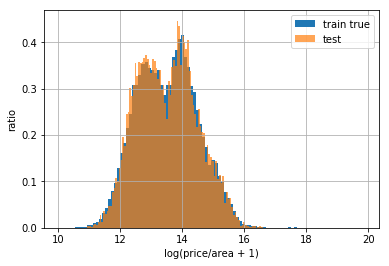

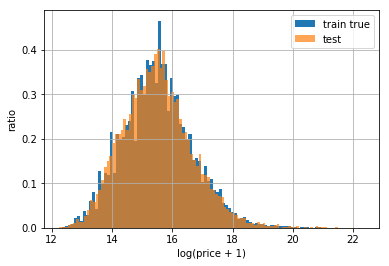

In [33]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

In [34]:
test[['building_id', 'total_price']].check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.395051e+07
1,BTshNOJyKHnT2YIT,3.929963e+06
2,dhdymr0lV8N5kZOT,1.111495e+07
3,VEwyGGMcD56w5BOc,6.030925e+06
4,wmUeMoJZfsqaSX9b,1.068454e+06
9995,UEeCDaAJzPwdKKKA,1.232403e+06
9996,i0fgbPaQsDWs7Q87,4.739648e+07
9997,YunNwAhcqkf6YclI,1.095955e+06
9998,A2NotxtRY9MYoWMl,2.978383e+06
9999,kKvgBXiA50gRmQhP,3.140833e+06


shape = (10000, 2)


In [35]:
output_filename = 'output/stack_mean_{}_{}.csv'.format(stack_idx, models)
print('Output file to:', output_filename)

Output file to: output/stack_mean_12_1-18,20.csv


In [36]:
test[['building_id', 'total_price']].to_csv(output_filename, index=False)

In [37]:
pd.read_csv(output_filename).check()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.395051e+07
1,BTshNOJyKHnT2YIT,3.929963e+06
2,dhdymr0lV8N5kZOT,1.111495e+07
3,VEwyGGMcD56w5BOc,6.030925e+06
4,wmUeMoJZfsqaSX9b,1.068454e+06
9995,UEeCDaAJzPwdKKKA,1.232403e+06
9996,i0fgbPaQsDWs7Q87,4.739648e+07
9997,YunNwAhcqkf6YclI,1.095955e+06
9998,A2NotxtRY9MYoWMl,2.978383e+06
9999,kKvgBXiA50gRmQhP,3.140833e+06


shape = (10000, 2)
